# Key words exploration

The objective of this section is to explore reviews in an attempt to find new keywords to add to the dictionary for keyword extraction. 
The procedure is as follows:
1. Randomly select a number of comments
2. Classify these comments into three categories using the BERT model
3. For each category, perform TF-IDF to identify the most symbolic words in the reviews

Device set to use cpu
100%|██████████| 16/16 [18:44<00:00, 70.26s/it]



Top words for category 'handicap':
room 0.067
location 0.061
clean 0.052
good 0.047
great 0.045
staff 0.043
breakfast 0.042
small 0.034
bed 0.029
rooms 0.028

Top words for category 'pet':
good 0.212
breakfast 0.132
centre 0.11
city 0.11
close 0.11
location 0.078
39 0.072
amazing 0.066
amp 0.066
beds 0.066

Top words for category 'child':
kids 0.128
la 0.094
hotel 0.079
relax 0.064
room 0.062
good 0.061
clean 0.053
price 0.052
amazing 0.051
club 0.051


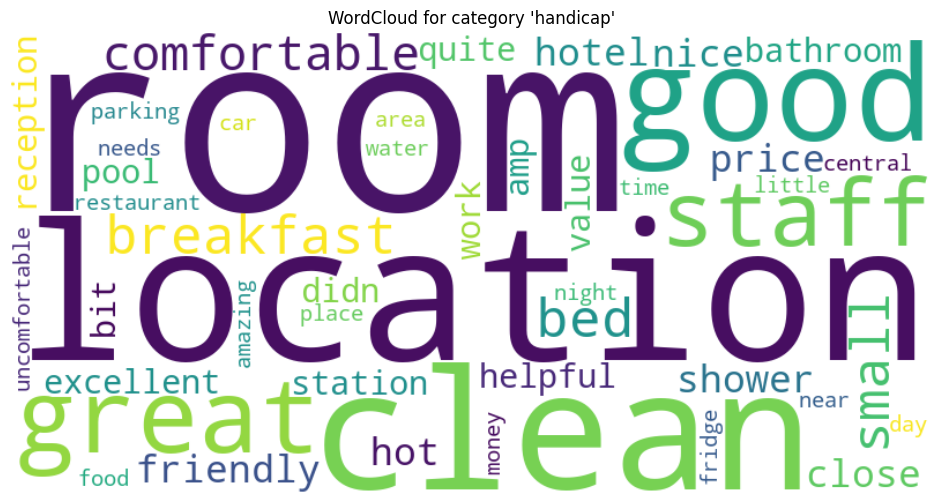

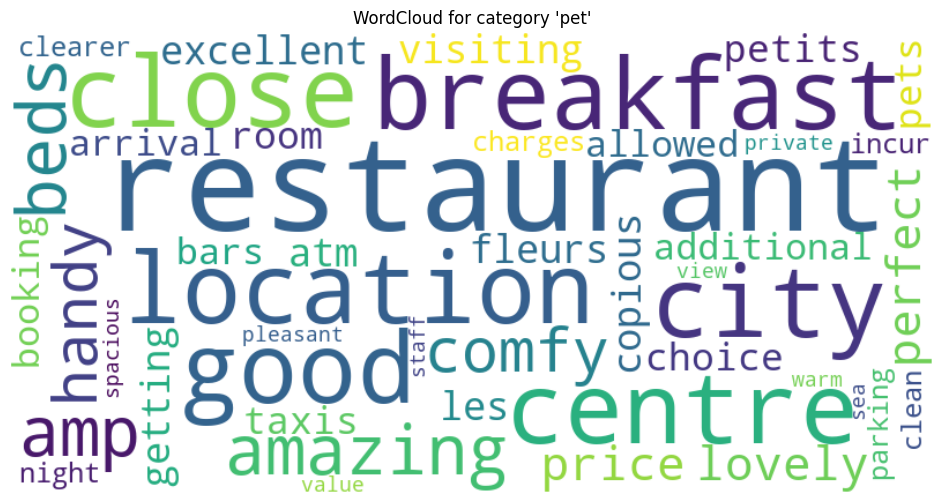

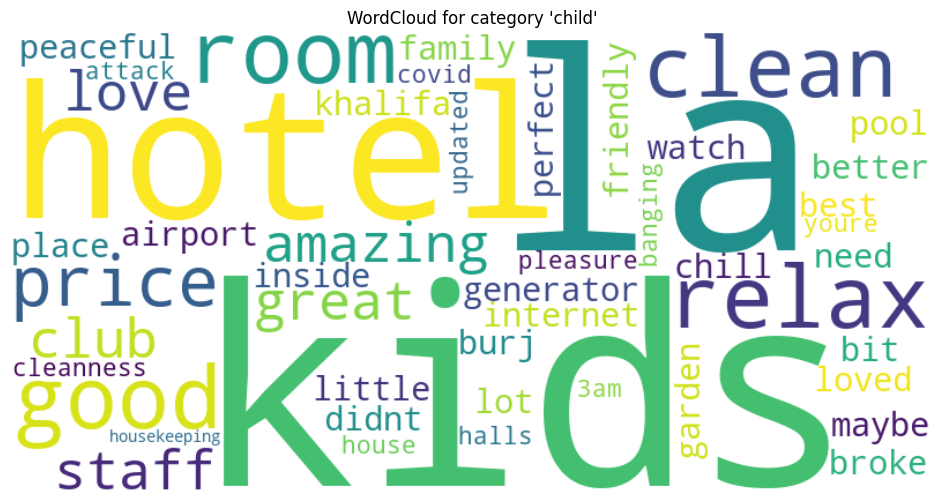

In [9]:
import torch
torch.set_num_threads(4)
from transformers import pipeline
import polars as pl
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm

# -------------------------------
# 1. Load the zero-shot model
# -------------------------------
device = 0 if torch.cuda.is_available() else -1
pipe = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=device
)

# -------------------------------
# 2. Load and clean the data
# -------------------------------
df = pl.read_csv("../../data/original/dataset/data_booking.csv")

# Drop or fill missing reviews
df = df.filter(pl.col("review").is_not_null())
df = df.sample(n=500, with_replacement=False, shuffle=True)

# Labels for zero-shot classification
labels = ["pet", "child", "handicap", "other"]

# -------------------------------
# 3. Predict categories in batch
# -------------------------------
batch_size = 32
predicted = []
texts = df["review"].to_list()

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]
    results = pipe(batch, candidate_labels=labels, multi_label=False)
    # results is a list of dicts
    predicted.extend([r["labels"][0] for r in results])

# Add predicted category to dataframe
df = df.with_columns(pl.Series("predicted_category", predicted))

# -------------------------------
# 4. TF-IDF analysis per category
# -------------------------------
categories_of_interest = ["handicap", "pet", "child"]
vectorizer = TfidfVectorizer(stop_words="english", lowercase=True, max_features=1000)

tfidf_per_category = {}

for cat in categories_of_interest:
    reviews_cat = df.filter(pl.col("predicted_category") == cat)["review"].to_list()
    if len(reviews_cat) == 0:
        continue
    X = vectorizer.fit_transform(reviews_cat)
    feature_names = vectorizer.get_feature_names_out()
    avg_tfidf = X.mean(axis=0).A1  # average TF-IDF per word
    tfidf_per_category[cat] = sorted(
        zip(feature_names, avg_tfidf),
        key=lambda x: x[1],
        reverse=True
    )

# -------------------------------
# 5. Display top words per category
# -------------------------------
for cat in categories_of_interest:
    print(f"\nTop words for category '{cat}':")
    if cat in tfidf_per_category:
        for word, score in tfidf_per_category[cat][:10]:
            print(word, round(score, 3))
    else:
        print("No reviews in this category.")

# -------------------------------
# 6. Optional: WordCloud per category
# -------------------------------
for cat in categories_of_interest:
    if cat not in tfidf_per_category:
        continue
    text = " ".join([w for w, score in tfidf_per_category[cat][:50]])  # top 50 words
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(12, 6))
    plt.title(f"WordCloud for category '{cat}'")
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [10]:
import json

# -------------------------------
# 7. Save keywords per category
# -------------------------------
with open("keywords_per_category_booking.json", "w", encoding="utf-8") as f:
    # On ne garde que les mots, pas les scores si tu veux juste les mots
    keywords_only = {cat: [w for w, score in tfidf_per_category[cat]] 
                     for cat in tfidf_per_category}
    json.dump(keywords_only, f, ensure_ascii=False, indent=4)



Top discriminant words for category 'handicap':
['shower', 'hot', 'helpful', 'station', 'quite', 'didn', 'reception', 'water', 'central', 'time']

Top discriminant words for category 'pet':
['handy', 'atm', 'copious', 'fleurs', 'les', 'petits', 'taxis', 'choice', 'pets', '15']

Top discriminant words for category 'child':
['kids', 'la', 'relax', 'club', 'generator', 'watch', 'burj', 'khalifa', 'broke', 'chill']


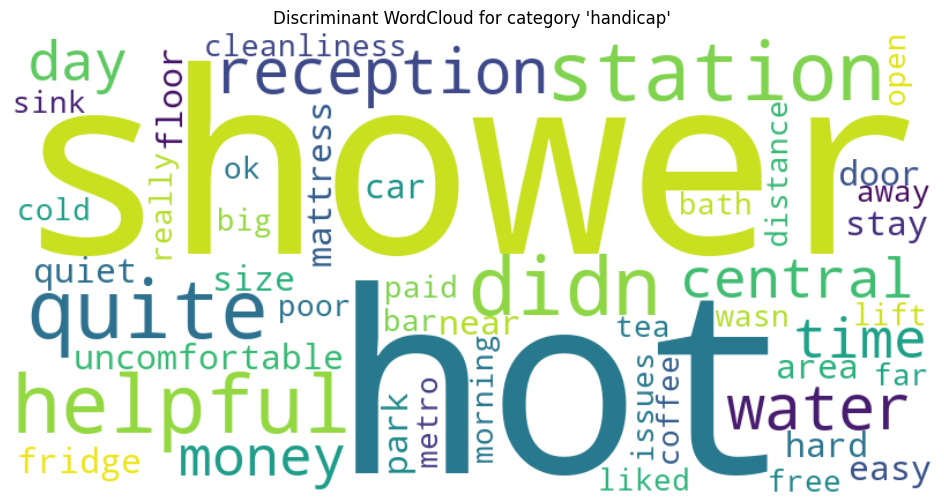

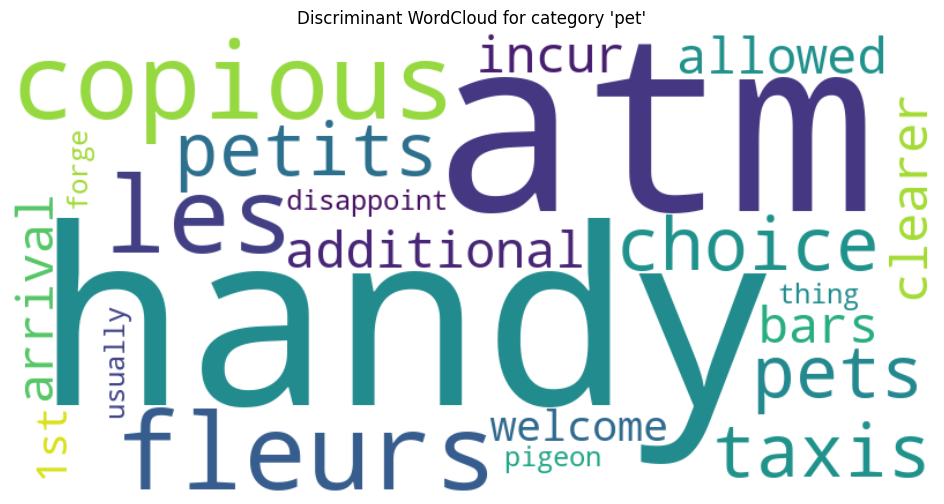

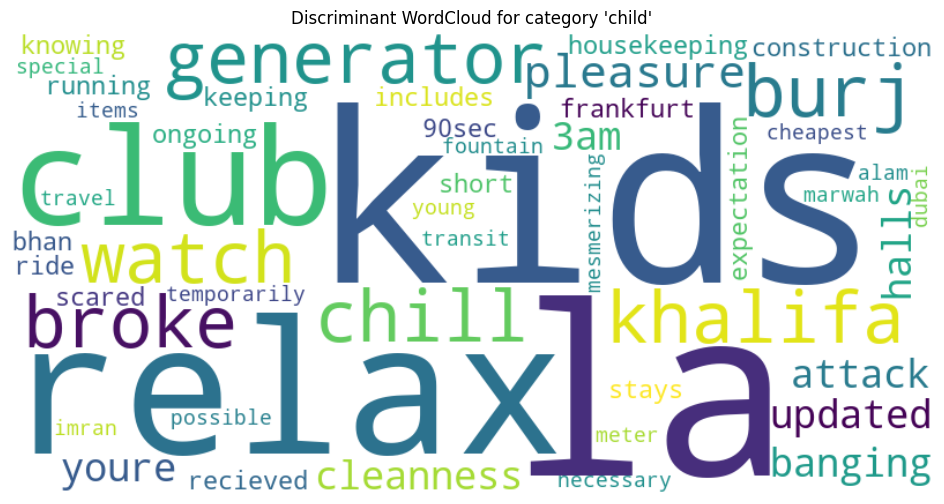

In [11]:
import json
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load TF-IDF words per category from JSON
# -------------------------------
with open("keywords_per_category_booking.json", "r") as f:
    tfidf_words = json.load(f)

# tfidf_words is a dict like:
# {
#   "handicap": ["room", "hotel", "location", ...],
#   "pet": ["dog", "friendly", "clean", ...],
#   "child": ["kids", "family", "playground", ...]
# }

categories = list(tfidf_words.keys())

# -------------------------------
# 2. Identify discriminant words per category
# -------------------------------
# Convert list to set for set operations
words_per_category = {cat: set(tfidf_words[cat]) for cat in categories}

discriminant_words = {}

for cat in categories:
    other_words = set()
    for other_cat in categories:
        if other_cat != cat:
            other_words.update(words_per_category[other_cat])
    
    # Words unique to this category
    discriminant_words[cat] = words_per_category[cat] - other_words

# -------------------------------
# 3. Sort discriminant words by original order (assuming JSON is sorted by importance)
# -------------------------------
top_discriminant_words = {}
for cat in categories:
    original_list = tfidf_words[cat]
    unique_set = discriminant_words[cat]
    # Keep only words in the unique set, preserve original order
    top_discriminant_words[cat] = [w for w in original_list if w in unique_set]

# -------------------------------
# 4. Display top discriminant words
# -------------------------------
for cat in categories:
    print(f"\nTop discriminant words for category '{cat}':")
    print(top_discriminant_words[cat][:10])  # top 10

# -------------------------------
# 5. Generate WordClouds for discriminant words
# -------------------------------
for cat in categories:
    words_text = " ".join(top_discriminant_words[cat][:50])  # top 50
    wc = WordCloud(width=800, height=400, background_color="white").generate(words_text)
    plt.figure(figsize=(12, 6))
    plt.title(f"Discriminant WordCloud for category '{cat}'")
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [8]:
import polars as pl

# --- 1. Charger le dataset avec les catégories prédictes ---


# On suppose que tu as une colonne "predicted_category"
categories = df["predicted_category"].unique().to_list()

# --- 2. Afficher les reviews par catégorie ---
for cat in categories:
    print(f"\n=== Reviews for category '{cat}' ===\n")
    # Filtrer les reviews de cette catégorie
    reviews_cat = df.filter(pl.col("predicted_category") == cat)["review"].to_list()
    
    # Afficher un nombre limité de reviews pour ne pas surcharger la console
    for r in reviews_cat[:10]:  # afficher seulement les 10 premières
        print("-", r)



=== Reviews for category 'child' ===

- Breakfast The bed was very soft
- We wanted to not be in Main Street in Byron, but was looking to walk into town easy, which it was! Only few mins to the bus terminal&#47;The rails Hotel that has really great food, and music every night (and a great low key casual vibe). The park is not too big, lots of trees, space and birds. We parked outside our cabin, lots of windows and natural light. We had a mini kitchen which was handy too. The walk to the beach prob about 15 mins, but it’s really easy, enjoyable via town. Gate security is really good! Lovely pool on site too. There wasnt really much space to hang beach towel, or wet clothes ( and they said not to hang stuff outside)  We helped an 85 yo traveller get a room, cause he didnt have a credit card for security, and they were nt going to give him the room.
- Econo Lodge is situated close to the center of Louisville, and in close vicinity to some important locations such as the Kentucky Internat